In [1]:
import difflib
import json
import os
import random
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

from language_classifier.language_classifier import LanguageClassifier

# formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# import data

In [2]:
# folders
parsed_docs_folder = os.path.join("..", "ParsedPublications")
fr_eng_correlation_csv = "fr_eng_correlation_data.csv"

fr_eng_correlation_df = pd.read_csv(fr_eng_correlation_csv)

# weblinks for previewing / testing
weblinks_df = fr_eng_correlation_df.copy()
weblinks_df = weblinks_df[['pub_number', 'nom', 'name', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

# simplified correlation table
fr_eng_correlation_df = fr_eng_correlation_df[['pub_number', 'filename_fr', 'filename_en']]

# helper functions

In [3]:
# DATA CLEANING FUNCTIONS

def clean_text(text):

    allowed_chars = r"[^a-zA-ZÀ-ÖØ-öø-ÿ.,;:!?()'\"-]"
    text = re.sub(allowed_chars, ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text


def get_files_for_publication(pub_number, fr_eng_correlation_df):
    row = fr_eng_correlation_df.loc[fr_eng_correlation_df['pub_number'] == pub_number]
    if not row.empty:
        filename_fr = row['filename_fr'].values[0]
        filename_en = row['filename_en'].values[0]
        return filename_fr, filename_en
    return None, None


def get_json_file_link(parsed_docs_folder, pdf_filename):
    if pdf_filename.endswith(".pdf"):
        json_filename = pdf_filename + ".json"
        for root, _, files in os.walk(parsed_docs_folder):
            if json_filename in files:
                return os.path.join(root, json_filename)
    return None


def extract_text_from_single_file(json_file, target_language, clf):
    min_block_length = 10
    max_block_length = 500
    
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = clean_text(data['text'])
    text_blocks = re.split(r'(?<![;,])[.?!]\s|\n\n', full_text)
    text = []

    for block in text_blocks:
        block = block.strip()
        if len(block) < min_block_length or len(block) > max_block_length:
            continue
        
        if clf.classify(block) == target_language:
            text.append(block + '. ')      

    return " ".join(text)


def extract_both_languages_from_two_files(json_file_fr, json_file_en, clf):
    return extract_text_from_single_file(json_file_fr, "fr", clf), extract_text_from_single_file(json_file_en, "en", clf)


def extract_both_languages_from_single_file(json_file, clf):
    min_block_length = 10
    max_block_length = 500
    
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = data['text']
    text_blocks = re.split(r'(?<![;,])[.?!]\s|\n\n', full_text)
    text_fr, text_en = [], []

    for block in text_blocks:
        block = block.strip()
        if len(block) < min_block_length or len(block) > max_block_length:
            continue
            
        if clf.classify(block) == "fr":
            text_fr.append(block + '. ')   
        elif clf.classify(block) == "en":
            text_en.append(block + '. ')   

    return " ".join(text_fr), " ".join(text_en)


def correlate_and_clean_text(text_fr, text_en):
    # TODO: update this to similarity matrix method
    matcher = difflib.SequenceMatcher(None, text_fr.split(), text_en.split())
    matched_fr, matched_en = [], []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            matched_fr.append(" ".join(text_fr.split()[i1:i2]))
            matched_en.append(" ".join(text_en.split()[j1:j2]))
    
    return matched_fr, matched_en


def process_all_rows(fr_eng_correlation_df, parsed_docs_folder, clf):
    debug = True  # TODO: remove after DEBUG
    
    matched_data = []
    min_text_quality = 1
    
    for _, row in fr_eng_correlation_df.iterrows():
        pub_number = row['pub_number']
        filename_fr, filename_en = row['filename_fr'], row['filename_en']
        
        if filename_fr == "WITHDRAWN" and filename_en == "WITHDRAWN":
            continue
        
        fr_link = get_json_file_link(parsed_docs_folder, filename_fr)
        if fr_link == None:
            continue
        
        if filename_fr == filename_en:
            text_fr, text_en = extract_both_languages_from_single_file(fr_link, clf)
        else:
            en_link = get_json_file_link(parsed_docs_folder, filename_en) 
            if en_link == None:
                continue
            text_fr, text_en = extract_both_languages_from_two_files(fr_link, en_link, clf            )
        
        if debug:
            matched_fr, matched_en = text_fr, text_en  # TODO: remove after DEBUG
        else:            
            matched_fr, matched_en = correlate_and_clean_text(text_fr, text_en)  # TODO: confirm
        
        matched_data.append({'pub_number': pub_number, 'text_fr': matched_fr, 'text_en': matched_en})
    
    return pd.DataFrame(matched_data)


def preview_publication(pub_number):
    if type(pub_number) is pd.DataFrame and pub_number.shape[0] == 1:
        try:
            pub_number = pub_number['pub_number'].values[0]
        except ValueError:
            return None
    elif type(pub_number) is pd.Series:
        try:
            pub_number = pub_number.values[0]
        except ValueError:
            return None
    
    try:
        output_df = weblinks_df[weblinks_df.pub_number == pub_number].T
    except Exception as e:
        print(e)
        return None
        
    display(output_df)


def preview_publication_by_row(row_n):
    display(pd.DataFrame(matched_df.iloc[row_n]))
    preview_publication(matched_df.iloc[row_n].pub_number)


In [4]:
clf = LanguageClassifier()

matched_df = process_all_rows(fr_eng_correlation_df, parsed_docs_folder, clf)
matched_df['len_fr'] = matched_df['text_fr'].str.len()
matched_df['len_en'] = matched_df['text_en'].str.len()
matched_df['len_diff'] = np.where(
    matched_df[['len_fr', 'len_en']].min(axis=1) == 0,
    999,
    matched_df[['len_fr', 'len_en']].max(axis=1) / matched_df[['len_fr', 'len_en']].min(axis=1)
)

In [104]:
# TODO: UPDATE THIS

def create_similarity_matrix(text_fr, text_en):
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

    sentences_fr = [x.strip() for x in re.split(r'(?<![;,])[.?!]\s|\n\n', text_fr) if x != ""]
    sentences_en = [x.strip() for x in re.split(r'(?<![;,])[.?!]\s|\n\n', text_en) if x != ""]
    
    embeddings_fr = model.encode(sentences_fr, convert_to_tensor=True)
    embeddings_en = model.encode(sentences_en, convert_to_tensor=True)

    return util.pytorch_cos_sim(embeddings_fr, embeddings_en)


def plot_similarity_heatmap(similarity_matrix, figsize=(10, 10), low_similarity=0.6, high_similarity=0.8, matched_pairs=None, cmap=None):
    fig, ax = plt.subplots(figsize=figsize) 
    
    if cmap:
        sns.heatmap(similarity_matrix, cmap=cmap, cbar=False, square=True, linewidths=0, ax=ax)
    else:
        cmap = mcolors.ListedColormap(["black", "darkblue", "deepskyblue"])
        bounds = [0, low_similarity, high_similarity, 1]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
        sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, square=True, linewidths=0, ax=ax)

    if matched_pairs:
        x_coords, y_coords = zip(*matched_pairs)
        ax.plot(x_coords, y_coords, marker='o', linestyle='-', color='red', markersize=4, linewidth=1.5)

    ax.tick_params(left=False, bottom=False)

    plt.tight_layout()
    plt.show()


def text_from_row(row_n):
    return matched_df.iloc[row_n]['text_fr'], matched_df.iloc[row_n]['text_en']


def text_from_pub_number(pub_number):
    return matched_df[matched_df.pub_number == pub_number].text_fr.values[0], matched_df[matched_df.pub_number == pub_number].text_en.values[0]


def display_similarity_matrix(row_n, inverse=False, figsize=(10, 10)):
    text_fr, text_en = text_from_row(row_n)
    similarity_matrix = create_similarity_matrix(text_fr, text_en)
    if inverse:
        plot_similarity_heatmap(similarity_matrix.T, figsize=figsize)
    else:
        plot_similarity_heatmap(similarity_matrix, figsize=figsize)
    

# TODO: consider replacing with manual merge during pathfinding through the similarity matrix
def merge_short_sentences(sentences, min_length=10):
    merged_sentences = []
    buffer = ""

    for sentence in sentences:
        if len(sentence) < min_length:
            buffer += " " + sentence
        else:
            if buffer:
                merged_sentences.append(buffer.strip() + " " + sentence)
                buffer = ""
            else:
                merged_sentences.append(sentence)

    if buffer:
        merged_sentences.append(buffer.strip())

    return merged_sentences


def correlate_and_clean_text(text_fr, text_en):
    # TODO: traverse matrix like tree or A*, 
    #  i and j must always increase, no jumping around 
    #  skip bad matches for both languages
    #  merge everything between good matches and recheck for match
    
    min_score = 0.7
    
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

    sentences_fr = [x.strip() for x in re.split(r'(?<![;,])[.?!]\s|\n\n', text_fr) if x != ""]
    sentences_en = [x.strip() for x in re.split(r'(?<![;,])[.?!]\s|\n\n', text_en) if x != ""]
    
    # TODO: merge short sentences

    embeddings_fr = model.encode(sentences_fr, convert_to_tensor=True)
    embeddings_en = model.encode(sentences_en, convert_to_tensor=True)

    similarity_matrix = util.pytorch_cos_sim(embeddings_fr, embeddings_en)

    matched_fr, matched_en = [], []
    used_en_indices = set()

    for i, emb_fr in enumerate(embeddings_fr):
        scores = similarity_matrix[i]
        best_match_idx = scores.argmax().item()
        
        if scores[best_match_idx] > min_score and best_match_idx not in used_en_indices:
            matched_fr.append(sentences_fr[i])
            matched_en.append(sentences_en[best_match_idx])
            used_en_indices.add(best_match_idx)

    return matched_fr, matched_en
    

In [6]:
row_n = 1000
text_fr, text_en = matched_df.iloc[row_n]['text_fr'], matched_df.iloc[row_n]['text_en']
similarity_matrix = create_similarity_matrix(text_fr, text_en)

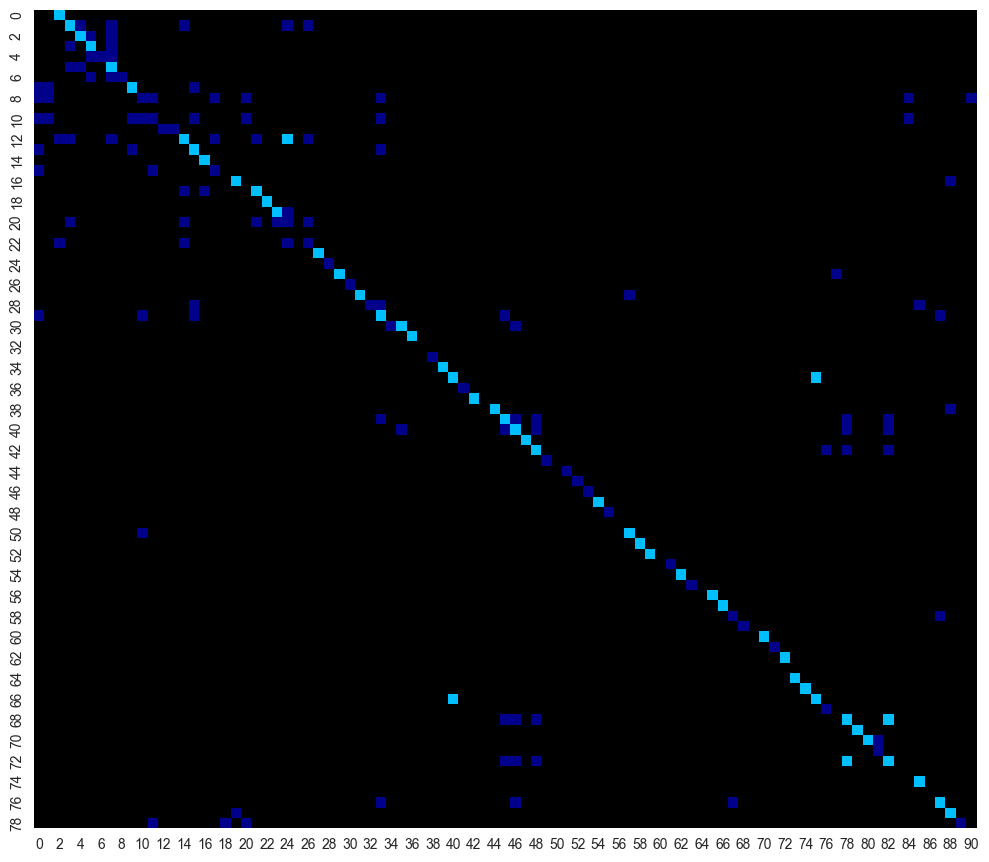

In [7]:
# no!, what happened
display_similarity_matrix(row_n)

In [8]:
# re.split(r'(?<![;,])([.?!]\s|\n\n)', text_fr[:200])
re.split(r'(?<![;,])[.?!]\s|\n\n', text_fr[:200])

['Mont-Joli, Québec, G H Z Avant-propos Le présent compte rendu a pour but de consigner les principales activités et discussions qui ont eu lieu au cours de la réunion',
 ' Il peut contenir des recommandat']

In [9]:
text_fr[:200].split('. ')


['Mont-Joli, Québec, G H Z Avant-propos Le présent compte rendu a pour but de consigner les principales activités et discussions qui ont eu lieu au cours de la réunion',
 ' Il peut contenir des recommandat']

# Junk Data (abstract only translations)

In [10]:
# let's look at the garbage data and see if we can fix it
min_doc_length = 1000
matched_df[((matched_df.len_fr < min_doc_length) | (matched_df.len_en < min_doc_length))].drop(['text_fr', 'text_en'], axis=1).sample(10)

,pub_number,len_fr,len_en,len_diff
3050,RES 1997/006,923,6201,6.7
1980,RES 1986/075,708,8411,11.9
1546,RES 1981/076,722,15480,21.4
2632,RES 1993/044,983,7759,7.9
8556,SSR 1999/C6-13,59,5489,93.0
1526,RES 1981/056,647,8104,12.5
82,PRO 1999/028,0,96200,999.0
2399,RES 1991/019,875,13957,16.0
1430,RES 1980/039,933,16682,17.9
1418,RES 1980/027,329,8435,25.6


In [11]:
matched_df.iloc[4000, 3:]

len_fr       4205
len_en      80713
len_diff     19.2
Name: 4000, dtype: object

In [12]:
n = 4000
# display_similarity_matrix(n)
text_fr, text_en = matched_df.iloc[n, 1], matched_df.iloc[n, 2]
# create_similarity_matrix(text_fr, text_en)
preview_publication_by_row(n)

,4000
pub_number,RES 2002/123
text_fr,S C C S\nSecrétariat canadien de consultation scientifique. Ne pas citer sans\nautorisation des...
text_en,C S A S\nCanadian Science Advisory Secretariat. Not to be cited without\npermission of the auth...
len_fr,4205
len_en,80713
len_diff,19.2


,4053
pub_number,RES 2002/123
nom,Examen de la biologie et de la pêche des Embiotocidés de la Colombie-Britannique.
name,A review of the biology and fishery of the Embiotocids of British Columbia.
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2002/2002_123-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2002/2002_123-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/272802.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/272802.pdf


In [13]:
diff_max = 5
matched_df[matched_df.len_diff > diff_max].shape[0]

4924

In [14]:
matched_df['len_diff'].describe()

count   8932.0
mean      43.3
std      167.7
min        1.0
25%        1.2
50%        8.3
75%       19.8
max     2711.8
Name: len_diff, dtype: float64

In [15]:
min_doc_chars = 1000
max_len_ratio = 5

matched_df.loc[(matched_df.len_fr > min_doc_chars) & (matched_df.len_en > min_doc_chars), 'len_diff'].describe()

count   8022.0
mean      11.8
std       17.0
min        1.0
25%        1.1
50%        5.3
75%       16.9
max      206.7
Name: len_diff, dtype: float64

In [16]:
junk_df = matched_df.loc[(matched_df.len_fr < min_doc_chars) | (matched_df.len_en < min_doc_chars) | (matched_df.len_diff > max_len_ratio)].copy()
junk_pub_numbers = junk_df['pub_number'].to_list() 
junk_df.loc[:, 'year'] = junk_df['pub_number'].str.extract(r'(\d{4})')
junk_df['year'] = pd.to_numeric(junk_df['year'], errors='coerce')

good_df = fr_eng_correlation_df[(~fr_eng_correlation_df.pub_number.isin(junk_pub_numbers)) & (fr_eng_correlation_df.filename_fr != "WITHDRAWN")].copy()
good_df.loc[:, 'year'] = good_df['pub_number'].str.extract(r'(\d{4})')
good_df['year'] = pd.to_numeric(good_df['year'], errors='coerce')

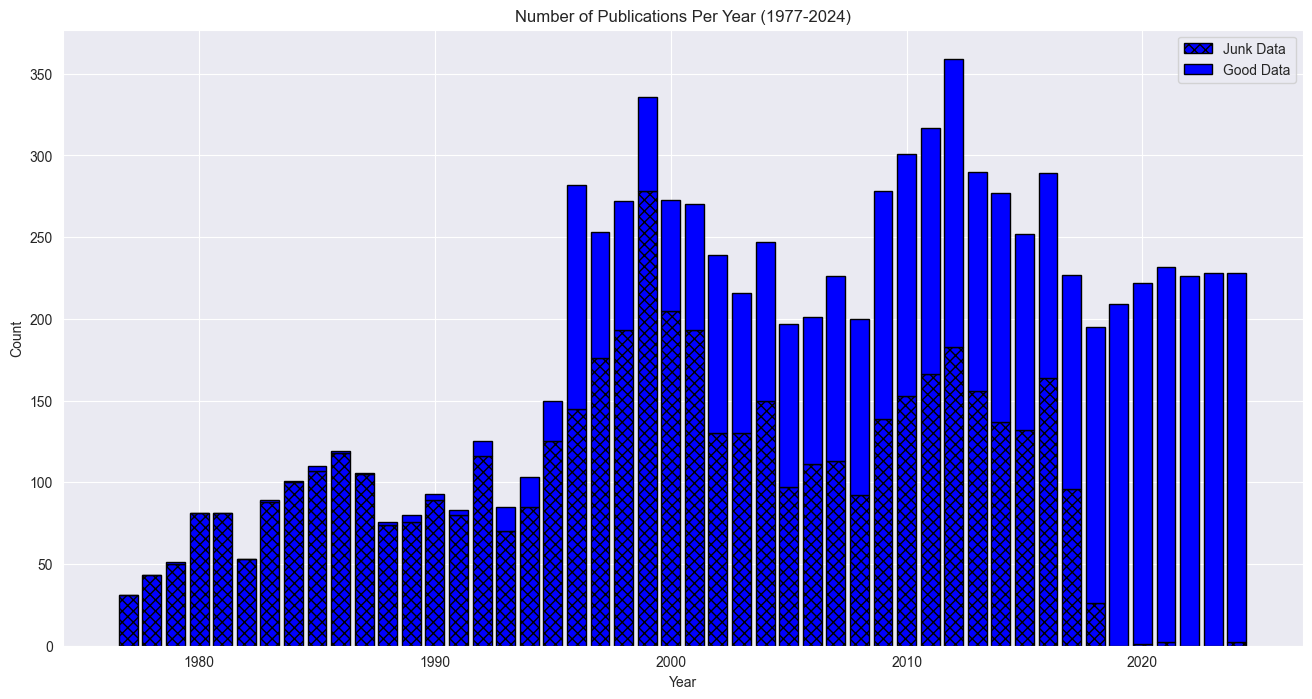

In [17]:
all_years = np.arange(1977, 2025)
junk_year_counts = junk_df['year'].value_counts().reindex(all_years, fill_value=0)
good_year_counts = good_df['year'].value_counts().reindex(all_years, fill_value=0)

plt.figure(figsize=(16, 8))
plt.bar(junk_year_counts.index, junk_year_counts.values, color='blue', edgecolor='black', label='Junk Data', hatch='xxx')
plt.bar(good_year_counts.index, good_year_counts.values, color='blue', edgecolor='black', label='Good Data', bottom=junk_year_counts.values)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Number of Publications Per Year (1977-2024)")
plt.legend()

plt.show()

In [18]:
# # CONFIRMED: only fr abstract, all else en 
# preview_publication_by_row(5412)
# preview_publication_by_row(5607)
# preview_publication_by_row(4605)
# preview_publication_by_row(3580)
# preview_publication_by_row(5457)
# preview_publication_by_row(4768)

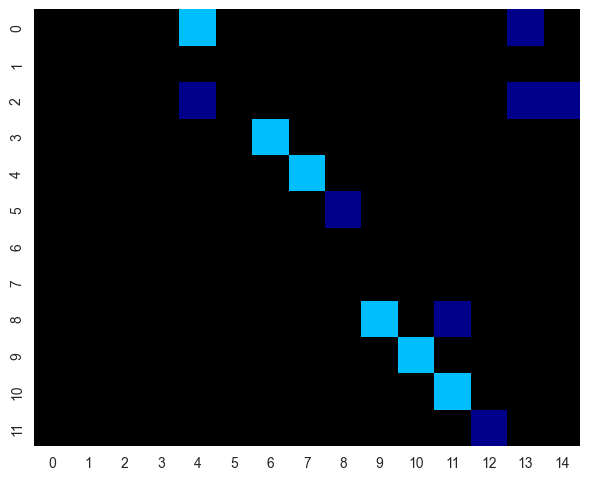

In [50]:
# only the abstract overlaps

text_fr, text_en = text_from_row(5607)
similarity_matrix = create_similarity_matrix(text_fr, text_en)

plot_similarity_heatmap(similarity_matrix[:, 135:150], figsize=(6, 5))

In [20]:
preview_publication_by_row(5607)

,5607
pub_number,RES 2016/066
text_fr,Cadre d'évaluation de la composante des reproducteurs d'automne du hareng de \nl'Atlantique (Clu...
text_en,Canadian Science Advisory Secretariat (CSAS). Assessment framework for fall-spawning Atlantic h...
len_fr,1864
len_en,73284
len_diff,39.3


,5680
pub_number,RES 2016/066
nom,Cadre d'évaluation de la composante des reproducteurs d'automne du hareng de l'Atlantique (Clupe...
name,Assessment framework for fall-spawning Atlantic herring (Clupea harengus) in the southern Gulf o...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2016/2016_066-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2016/2016_066-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/365980.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/365980.pdf


# decide whether to import abstract only translations

In [21]:
# how many are single file en / fr? 
#  basically all of them

junk_filenames = fr_eng_correlation_df[fr_eng_correlation_df.pub_number.isin(junk_pub_numbers)]  # does not include withdrawn

(
    junk_filenames[junk_filenames.filename_en == junk_filenames.filename_fr].shape[0], 
    junk_filenames[junk_filenames.filename_en != junk_filenames.filename_fr].shape[0]
)

(4936, 6)

In [22]:
# nearly all fr text is lower, which is consistent with the abstract only translations
junk_df[junk_df.len_fr < junk_df.len_en].shape[0], junk_df[junk_df.len_fr > junk_df.len_en].shape[0]

(4672, 242)

In [23]:
# how many single file translations are good? 
#  542 vs 3522 double file translations

good_filenames = fr_eng_correlation_df[(~fr_eng_correlation_df.pub_number.isin(junk_pub_numbers)) & (fr_eng_correlation_df.filename_fr != "WITHDRAWN")]
(
    good_filenames[good_filenames.filename_fr == good_filenames.filename_en].shape[0],
    good_filenames[good_filenames.filename_fr != good_filenames.filename_en].shape[0],
)

(539, 3522)

In [24]:
# check len ratio and len min

def print_n_docs(char_n=None, len_ratio=None):
    if char_n:
        if len_ratio:
            print(matched_df.loc[(matched_df.len_fr < char_n) | (matched_df.len_en < char_n) | (matched_df.len_diff > len_ratio)].shape[0])
        else:
            print(matched_df.loc[(matched_df.len_fr < char_n) | (matched_df.len_en < char_n)].shape[0])
    elif len_ratio:
        print(matched_df.loc[matched_df.len_diff > len_ratio].shape[0])
    else:
        print(matched_df.shape[0])
    

In [25]:
print_n_docs(char_n=1000, len_ratio=5)
print_n_docs(char_n=1000)
print_n_docs(len_ratio=5)
print_n_docs(len_ratio=3)

4942
909
4924
5035


In [26]:
# let's look at len ratio between 3 and 5 - all look like only the abstract is translated
medium_filenames = matched_df.loc[(matched_df.len_diff >= 3) & (matched_df.len_diff < 5)].copy()

medium_pub_numbers = medium_filenames.pub_number.to_list()

medium_filenames.sample(10)

,pub_number,text_fr,text_en,len_fr,len_en,len_diff
1877,RES 1985/081,Ne pas citer sans \nautorisation des auteursI. Cbnite scientifique consultatif des \npecbes can...,tibt to be cited without \npemdssion of the authorsl. canadian Atlantic Fisheries \nScientific ...,8344,1805,4.6
2413,RES 1991/033,'cette serle documente les bases \nscientifiques des oonseils de gestion \ndes peches sur la cOt...,"Moncton, New Brunswick. ''!his series documents the scientific \nbasis for fisheries management...",6847,24488,3.6
2963,RES 1996/061,Ne pas citer sans\nautorisation des auteurs'. MPO Pêches de l'Atlantique DFO Atlantic Fisheries...,Not to be cited without\npermission of the authors'. 'This series documents the scientific basi...,10579,2571,4.1
3837,RES 2001/113,S C C S\nSecrétariat canadien de consultation scientifique. * La présente série documente les b...,C S A S\nCanadian Science Advisory Secretariat. * This series documents the scientific basis fo...,2694,13253,4.9
2738,RES 1994/074,Ne pas citer sans\nautorisation des auteurs '. MPO Pêches de l'Atlantique\nDocument de recherch...,Not to be cited without\npermission of the authors'. Department of Fisheries and Oceans\nP. Jo...,1397,6552,4.7
4256,RES 2004/124,Secrétariat canadien de consultation scientifique. * La présente série documente les bases \nsc...,Canadian Science Advisory Secretariat. * This series documents the scientific basis for the \ne...,4559,19430,4.3
2699,RES 1994/035,DFO Atlantic Fisheries MPO Pêches de l'Atlantique\nResearch Document 94/35 Document de recherche...,'This series documents the scientific basis for the\nevaluation of fisheries resources in Atlant...,12089,2509,4.8
650,PRO 2011/057,Secrétariat canadien de consultation scientifique. Atelier régional sur les résultats \nprélimi...,Canadian Science Advisory Secretariat. Regional workshop on preliminary \nresults from the mult...,7729,1945,4.0
2378,RES 1990/091,Ne pas citer sans\nautorisation des auteurs i. Comite scientifique consultatif des\np€ches cana...,Not to be cited without\npermission of the authors '. Canadian Atlantic Fisheries\nScientific A...,6499,22108,3.4
435,PRO 2007/049,Secrétariat canadien de consultation scientifique. Compte rendu de la réunion du sous-\ncomité ...,Canadian Science Advisory Secretariat. Proceedings of the PSARC \nInvertebrate Subcommittee Mee...,4282,20884,4.9


In [27]:
# only abstract translated (short body): 4986, 2879, 3728
preview_publication(random.choice(medium_pub_numbers))

,3429
pub_number,RES 1999/044
nom,NaN
name,"Relative strength of the 1998 year-class, from nearshorre surveys of demersal age 0 Atlantic cod..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1999/1999_044-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/1999/1999_044-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/242293.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/242293.pdf


In [28]:
# what about a ratio of 2? -> only 22 more beyond what is already in 3
print_n_docs(len_ratio=2)

5054


In [29]:
medium_filenames = matched_df.loc[(matched_df.len_diff >= 2) & (matched_df.len_diff < 3)].copy()
medium_pub_numbers = medium_filenames.pub_number.to_list()
medium_filenames.drop(['text_fr', 'text_en'], axis=1)

,pub_number,len_fr,len_en,len_diff
238,PRO 2003/038,10559,28872,2.7
287,PRO 2004/010,92931,187667,2.0
400,PRO 2007/011,2262,6762,3.0
707,PRO 2012/031,22965,48544,2.1
1630,RES 1983/024,928,2602,2.8
2520,RES 1992/057,16365,5556,2.9
2746,RES 1994/082,17903,6596,2.7
2760,RES 1994/096,7615,19245,2.5
2955,RES 1996/053,28081,9461,3.0
3596,RES 2000/041,28631,61773,2.2


In [30]:
# with matching filenames
#  only partially translated: a bit more complicated than the abstract only (forward, attached letter, etc)
weblinks_df.loc[weblinks_df.pub_number.isin(medium_pub_numbers) & (weblinks_df.file_url_fr == weblinks_df.file_url_en), ['pub_number', 'file_url_fr', 'file_url_en']]

,pub_number,file_url_fr,file_url_en
246,PRO 2003/038,http://waves-vagues.dfo-mpo.gc.ca/Library/277995.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/277995.pdf
295,PRO 2004/010,http://waves-vagues.dfo-mpo.gc.ca/Library/282946.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/282946.pdf
412,PRO 2007/011,http://waves-vagues.dfo-mpo.gc.ca/Library/328381.pdf,http://waves-vagues.dfo-mpo.gc.ca/Library/328381.pdf
1658,RES 1983/024,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/38999.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/38999.pdf
2548,RES 1992/057,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/139073.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/139073.pdf
2774,RES 1994/082,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/179482.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/179482.pdf
2788,RES 1994/096,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/180433.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/180433.pdf
2983,RES 1996/053,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/198102.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/198102.pdf
4379,RES 2005/088,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/321068.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/321068.pdf


In [31]:
# with different files 
#  these may all be errors (every one I checked was a website linking error)
weblinks_df.loc[weblinks_df.pub_number.isin(medium_pub_numbers) & (weblinks_df.file_url_fr != weblinks_df.file_url_en), ['pub_number', 'file_url_fr', 'file_url_en']]

,pub_number,file_url_fr,file_url_en
719,PRO 2012/031,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347497.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347496.pdf
3642,RES 2000/041,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/265909.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/248180.pdf
5300,RES 2013/027,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/349926.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/349680.pdf
6338,RES 2024/046,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/4126082x.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41260818.pdf
6922,SAR 2012/045,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348373.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348324.pdf
7761,SCR 2012/041,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347658.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347657.pdf
7839,SCR 2014/033,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363608.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363607.pdf
8215,SCR 2022/024,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41063995.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41064951.pdf
8242,SCR 2023/004,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41107585.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41107020.pdf
8308,SCR 2024/026,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/4124946x.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41249422.pdf


# ERRORS IN DATA

In [32]:
# this is just wrong - the french link is SAR 2012/031, not PRO 2012/031 - these really should have different numbers 
#  https://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_031-fra.html
# preview_publication('PRO 2012/031')

In [33]:
# also wrong - the french link is wrong on the website
#  https://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-fra.htm
# preview_publication("RES 2000/041")

In [34]:
# the first 3 I checked had incorrect french links on the website - I assume all of these are bad data
for pub in weblinks_df[weblinks_df.pub_number.isin(medium_pub_numbers) & (weblinks_df.file_url_fr != weblinks_df.file_url_en)].pub_number.to_list():
    preview_publication(pub)

,719
pub_number,PRO 2012/031
nom,"Compte rendu de l'examen zonal par les pairs du repérage des stocks, de l'abondance, de la viabi..."
name,"Proceedings of the Zonal Peer Review of Stock Identification, Abundance, Hunt Sustainability, an..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_031-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_031-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347497.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347496.pdf


,3642
pub_number,RES 2000/041
nom,NaN
name,"Status of Atlantic salmon (Salmo salar L.) In Indian bay Brook, Middle Brook, and Terra Nova Riv..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/265909.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/248180.pdf


,5300
pub_number,RES 2013/027
nom,Une syntèse nationale des initiatives de recherche écosystémique de Pêches et Océans Canada
name,A National Synthesis of the Fisheries and Oceans Canada Ecosystem Research Initiative
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_027-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_027-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/349926.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/349680.pdf


,6338
pub_number,RES 2024/046
nom,Répartition spatio-temporelle de la baleine noire de l'Atlantique Nord dans le golfe du Saint-La...
name,Time-Space Distribution of North Atlantic Right Whale in Gulf of St. Lawrence from Acoustic Moni...
url_fr,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2024/2024_046-fra.html
url_en,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2024/2024_046-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/4126082x.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41260818.pdf


,6922
pub_number,SAR 2012/045
nom,"Évaluation de l'inconnu (Stenodus leucichthys) de la rivière Buffalo, Grand lac des Esclaves, Te..."
name,"Assessment of Buffalo River Inconnu (Stenodus leucichthys) Great Slave Lake, Northwest Territori..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348373.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348324.pdf


,7761
pub_number,SCR 2012/041
nom,Probabilité que les stocks de crevette tachetée (Pandalus platyceros) se trouvant dans les zones...
name,Probability of spot prawn (Pandalus platyceros) stocks in fall survey areas in British Columbia ...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2012/2012_041-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2012/2012_041-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347658.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347657.pdf


,7839
pub_number,SCR 2014/033
nom,Évaluation de la possibilité de rouvrir les zones de fermeture A et B du Grand Lac des esclaves
name,Assessment of the potential to re-open Great Slave Lake Closure Zones A and B
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/scr-rs/2014/2014_033-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2014/2014_033-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363608.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/363607.pdf


,8215
pub_number,SCR 2022/024
nom,Mise à jour de 2021 sur l'abondance des reproducteurs et les caractéristiques biologiques du bar...
name,Update of spawner abundance and biological characteristics of Striped Bass (Morone saxatilis) in...
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2022/2022_024-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2022/2022_024-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41063995.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41064951.pdf


,8242
pub_number,SCR 2023/004
nom,Mise à jour sur l'abondance de reproducteurs et les caractéristiques biologiques du bar rayé (Mo...
name,Update of spawner abundance and biological characteristics of Striped Bass (Morone saxatilis) in...
url_fr,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2023/2023_004-fra.html
url_en,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2023/2023_004-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41107585.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41107020.pdf


,8308
pub_number,SCR 2024/026
nom,Conséquence pour la conservation du déplacement de la limite nord de la zone de prise totale aut...
name,Conservation Implications of Moving the Northern Boundary of the Belcher-Islands and Eastern Hud...
url_fr,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2024/2024_026-fra.html
url_en,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ScR-RS/2024/2024_026-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/4124946x.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41249422.pdf


In [36]:
# what about all messed up len ratio with different files? 
#  mostly website errors
#  some same file copied to 2 filenames, only summary translated
bad_pub_numbers = matched_df.loc[(matched_df.len_diff > 2)].pub_number.to_list()
weblinks_df.loc[weblinks_df.pub_number.isin(bad_pub_numbers) & (weblinks_df.file_url_fr != weblinks_df.file_url_en), ['pub_number', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

,pub_number,url_fr,url_en,file_url_fr,file_url_en
719,PRO 2012/031,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_031-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_031-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347497.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/347496.pdf
737,PRO 2012/059,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_059-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/Pro-Cr/2012/2012_059-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348617.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348616.pdf
3642,RES 2000/041,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-fra.htm,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2000/2000_041-eng.htm,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/265909.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/248180.pdf
5275,RES 2013/002,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_002-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_002-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348703.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348701.pdf
5300,RES 2013/027,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_027-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2013/2013_027-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/349926.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/349680.pdf
6212,RES 2023/026,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2023/2023_026-fra.html,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2023/2023_026-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41117748.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41117554.pdf
6338,RES 2024/046,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2024/2024_046-fra.html,https://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2024/2024_046-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/4126082x.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41260818.pdf
6767,SAR 2010/070,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2010/2010_070-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2010/2010_070-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/343603.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/343602.pdf
6843,SAR 2011/067,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2011/2011_067-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2011/2011_067-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/346314.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/346313.pdf
6922,SAR 2012/045,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-fra.html,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/SAR-AS/2012/2012_045-eng.html,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348373.pdf,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/348324.pdf


In [37]:
# different file link, but identical file - only summary translated 
matched_df[matched_df.pub_number == 'PRO 2012/059'].T

,725
pub_number,PRO 2012/059
text_fr,"rostriformis bugenis), qui sont toutes deux originaires de la région pontocaspienne, en Europe o..."
text_en,Canadian Science Advisory Secretariat (CSAS) Proceedings Series National Capital Region May Proc...
len_fr,1738
len_en,33128
len_diff,19.1


In [38]:
# is correct? (yes)
preview_publication("RES 2018/029")
matched_df[matched_df.pub_number == 'RES 2018/029'].T

,5851
pub_number,RES 2018/029
nom,"Abondance de la population, caractéristiques biologiques et contribution aux pêches côtières de ..."
name,"Population abundance, biological characteristics, and contribution to coastal mixed-stock fisher..."
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2018/2018_029-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2018/2018_029-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40759489.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/40759453.pdf


,5777
pub_number,RES 2018/029
text_fr,Elle traite des problèmes courants selon les échéanciers dictés. Les documents qu elle contient...
text_en,Canadian Science Advisory Secretariat (CSAS) Research Document Central and Arctic Region October...
len_fr,62526
len_en,69051
len_diff,1.1


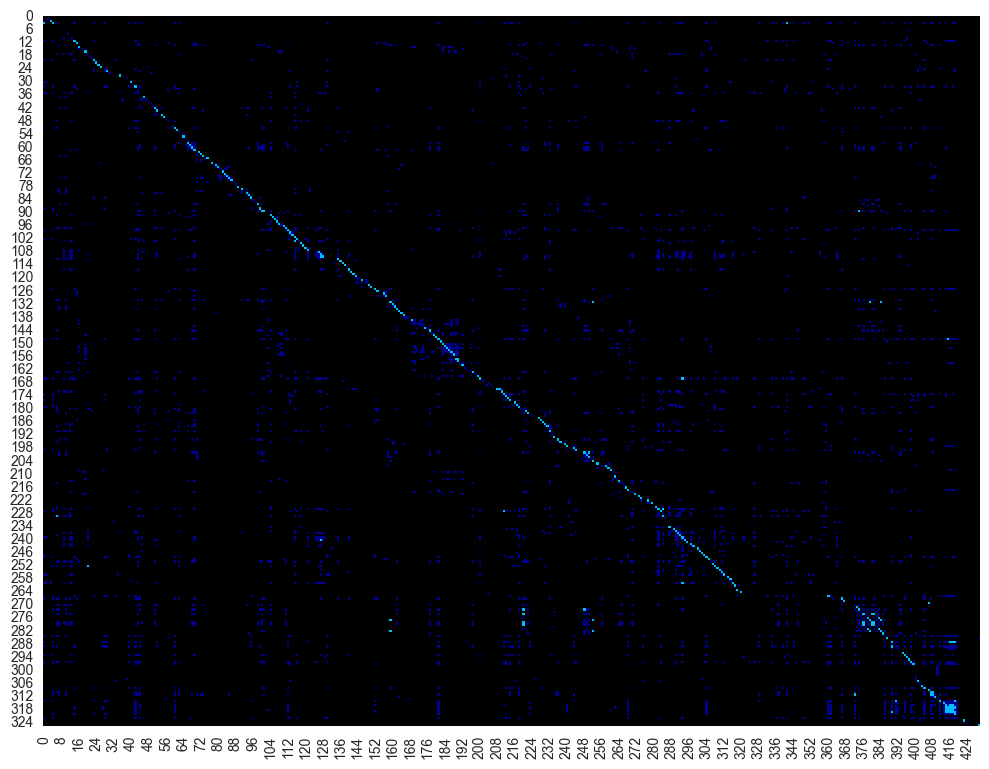

In [52]:
# NOTE: 'RES 2018/029' is now fixed with new min/max block sizes

# old notes:
# way more en than fr but actually matches
#  looks like a bunch of tables only got translated to english, wrecking the char ratio, even thoug the chunk ratio is less than 2
text_fr, text_en = text_from_pub_number('RES 2018/029')
similarity_matrix_5851 = create_similarity_matrix(text_fr, text_en)
plot_similarity_heatmap(similarity_matrix_5851)

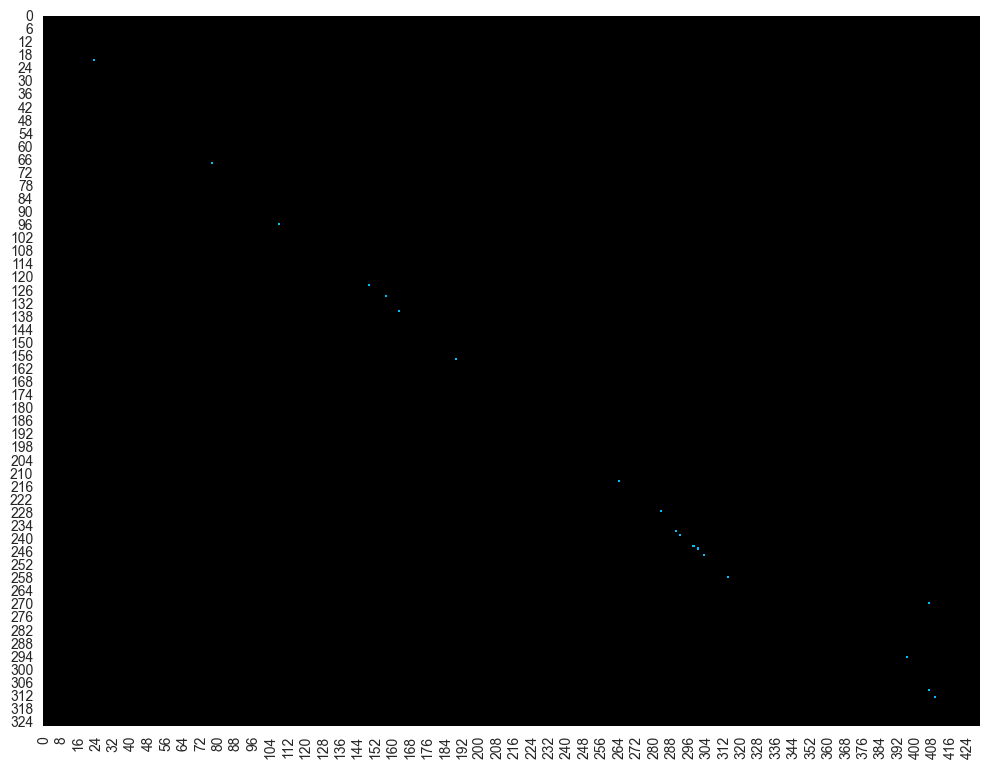

In [77]:
plot_similarity_heatmap(similarity_matrix_5851, low_similarity=0.95, high_similarity=0.95)

In [99]:
def diagonal_constrained_alignment(similarity_matrix, high_thresh=0.95, low_thresh=0.7):
    high_confidence = np.where(similarity_matrix > high_thresh)
    anchors = list(zip(high_confidence[0], high_confidence[1]))

    anchors = sorted(anchors, key=lambda x: x[0])

    filtered_pairs = [anchors[0]]

    for i in range(1, len(anchors)):
        prev_i, prev_j = filtered_pairs[-1] 
        curr_i, curr_j = anchors[i]

        if curr_i > prev_i and curr_j > prev_j:  # TODO: this doesn't solve the diagonal issue
            filtered_pairs.append((curr_i, curr_j))
    
    # # TODO: this part doesn't work - fill in (possibly recursively)
    # for (i1, j1) in anchors:
    #     for (i2, j2) in anchors:
    #         if i1 >= i2 or j1 >= j2:
    #             continue
    # 
    #         sub_matrix = similarity_matrix[i1:i2+1, j1:j2+1]
    #         max_sim_index = np.unravel_index(np.argmax(sub_matrix), sub_matrix.shape)
    #         best_i, best_j = max_sim_index[0] + i1, max_sim_index[1] + j1
    # 
    #         if similarity_matrix[best_i, best_j] > low_thresh:
    #             matched_pairs.add((best_i, best_j))

    return filtered_pairs


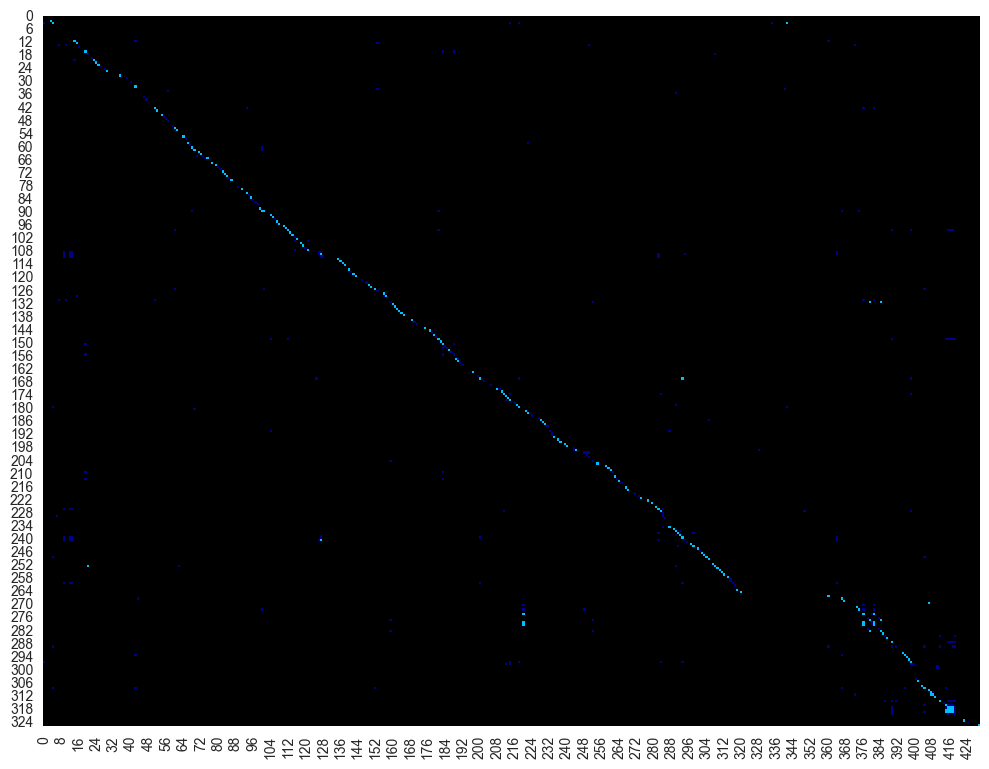

In [103]:
matched_pairs = diagonal_constrained_alignment(similarity_matrix_5851)
matched_pairs = [(y, x) for (x, y) in matched_pairs]

plot_similarity_heatmap(
    similarity_matrix_5851, 
    low_similarity=0.75, 
    high_similarity=0.85, 
    matched_pairs=None
)

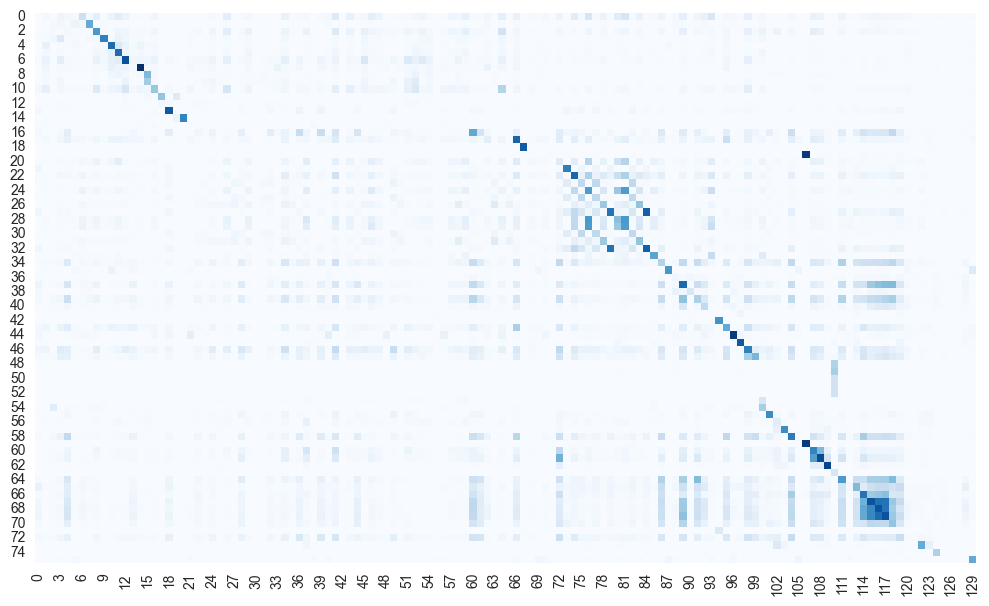

In [111]:
# TODO: how would we traverse this section 
plot_similarity_heatmap(similarity_matrix_5851[250:, 300:]**5, cmap="Blues")

<Axes: >

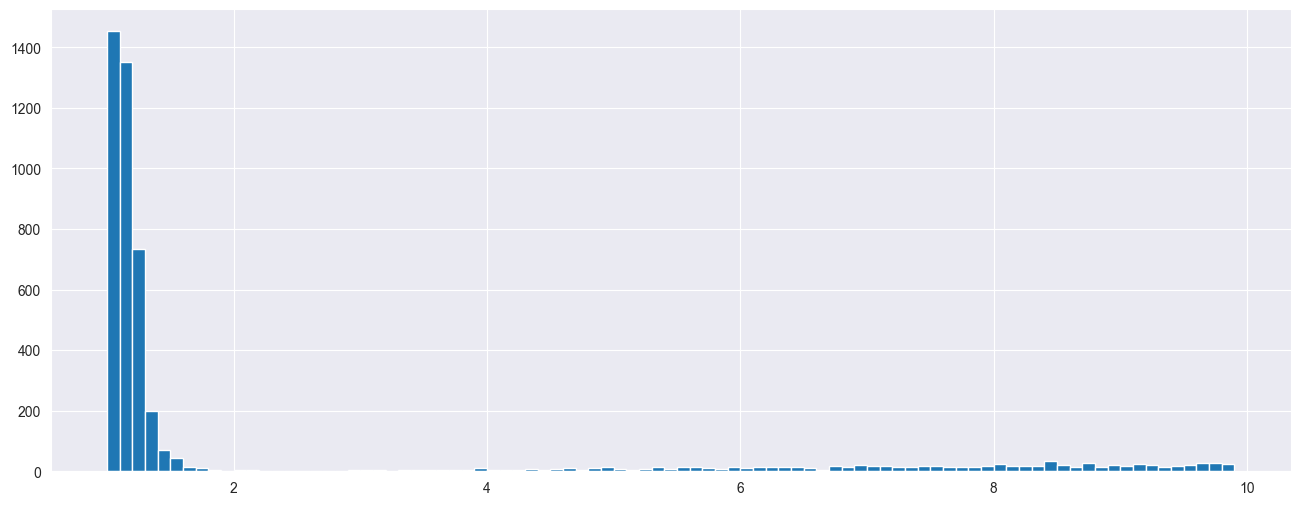

In [63]:
# let's make a histogram for len_diff, and try to guess where the good data starts
matched_df.len_diff.hist(bins=[x/10 for x in range(10, 100)], figsize=(16, 6))

In [45]:
# count number of characters good vs junk (ie, what percentage of the data is in these partially translated files)
